# Be safe - who is in the biggest need for PPE?

In the time of Coronavirus outbreak, as a fresh graduate of Data Science, I would like to utilize my skills and help the World, as the World someday may help me. The goal of this notebook is to find by observation places and people that are in the biggest need of the Personal Protective Equipment (PPE) in the COVID-19 time.

For the analysis, I was using the following datasets:

* ECDC/current-data-on-the-geographic-distribution-of-covid-19-cases-worldwide.csv - dataset presenting the daily number of cases/deaths around all of the countries in the world.
* johns_hopkins_csse/johns-hopkins-covid-19-daily-dashboard-cases-by-country.csv - another dataset showing the number of cases for countries, but showing only the most actual value (dataset is updating on the Kaggle).
* covidindicators/inform-covid-indicators.csv - contains country data with different information like density, percentage of people in urban areas, sanitation services etc. - this dataset is re-uploaded by myself, as it disappeared after dataset update.
* esri_covid-19/definitive-healthcare-usa-hospital-beds.csv - various data about USA hospitals (number of staff, types of beds etc.)
* covid_tracking_project/covid-statistics-by-us-states-totals.csv - data about sick people in the US with information about hospitalized people.
* HDE/acaps-covid-19-government-measures-dataset.csv - information about goverment measures.
* our_world_in_data/covid-19-testing-all-observations.csv - information about testing performed by different countries

The Uncover dataset and this notebook are keep updated, so somtimes the comments to the diagrams are splitted to sections: 1st iteration, 2nd iteration to reflect major iteration changes. The time between observed dataset updates is around 1 month - the date reflect the date from the dataset.

Now first let's import all of the python packages that may be useful during the analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('dark')

First let's take the dataset about the infection in different countries.

In [ ]:
ecdc_infections = pd.read_csv('/kaggle/input/uncover/ECDC/current-data-on-the-geographic-distribution-of-covid-19-cases-worldwide.csv')
ecdc_infections["daterep"] = pd.to_datetime(ecdc_infections[["year","month","day"]])
ecdc_latest_date = ecdc_infections.sort_values(by="daterep", ascending=False)["daterep"].values[0]
ecdc_infections.head()

This dataset is not showing the active number of cases, so let's calculate it.

In [ ]:
ecdc_infections["cum_cases"] = 0
ecdc_infections["cum_deaths"] = 0
codes = ecdc_infections["geoid"].drop_duplicates().values

for code in codes:
    infections = ecdc_infections[ecdc_infections["geoid"]==code].sort_values("daterep")["cases"].cumsum()
    deaths = ecdc_infections[ecdc_infections["geoid"]==code].sort_values("daterep")["deaths"].cumsum()
    indexes = infections.index
    inf_index=0
    for inf in infections:
        ecdc_infections.loc[indexes[inf_index], "cum_cases"] = inf
        inf_index+=1
    death_index=0
    death_indexes = deaths.index
    for death in deaths:
        ecdc_infections.loc[death_indexes[death_index], "cum_deaths"] = death
        death_index+=1 
ecdc_infections["active_cases"] = ecdc_infections["cum_cases"] - ecdc_infections["cum_deaths"]
ecdc_infections.head()

Now, let's read infection data, but this data is cumulative number of the cases per country.

In [ ]:
infections = pd.read_csv('/kaggle/input/uncover/johns_hopkins_csse/johns-hopkins-covid-19-daily-dashboard-cases-by-country.csv')
infections.head()

This dataset contains various data about countries, I'm reading it and cleaning the columns about the populations in the urban areas.

In [ ]:
country_information = pd.read_csv('/kaggle/input/covidindicators/inform-covid-indicators.csv')
country_information["population_living_in_urban_areas"] = country_information["population_living_in_urban_areas"].replace('No data', None)
country_information["population_living_in_urban_areas"] = country_information["population_living_in_urban_areas"].astype('float64')
country_information.head()

Now I'm taking the dataset about the testing in different countries and clean the column with country name.

In [ ]:
country_testing = pd.read_csv('/kaggle/input/uncover/our_world_in_data/covid-19-testing-all-observations.csv')
country_testing['entity'] = country_testing.entity.str.split('-').str[0]
country_testing['entity'] = country_testing.entity.str.rstrip()
country_testing.head()

And here I'm reading the dataset about the goverment measures done in different countries.

In [ ]:
goverment_measures = pd.read_csv('/kaggle/input/uncover/HDE/acaps-covid-19-government-measures-dataset.csv')
goverment_measures.head()

## How infection was changing for the most infected countries?

For this section, I would like to investigate how the number of active cases was changing for the most infected countries that I have data available.

First let's see how the infections were changing for the top 10 countries with the highest rate of the infections in the ECDC dataset, at the latest date in the dataset.

In [ ]:
d = ecdc_infections.copy()
d = d.drop(["day", "month", "year", "geoid", "countryterritorycode", "popdata2018"], axis=1)
d = d.groupby(["countriesandterritories","daterep"]).sum().unstack(level=0)
most_infected_countries = d[d.index==ecdc_latest_date].xs("active_cases", axis=1).sort_values(by=ecdc_latest_date, axis=1, ascending=False).iloc[:, 0:10].columns

In [ ]:
plt.clf()
plt.figure(figsize=(25,15))
ax = sns.lineplot(data=d.xs("active_cases", axis=1)[most_infected_countries], dashes=False)
i=0
for label in ax.get_xticklabels():
    if i%10!=0:
        label.set_visible(False)
    i+=1
plt.show()

We can see that the infections on this diagram started rising around the middle of February (the start of infections in Italy), this diagram is not so informative, so let's draw diagrams for each of these countries starting at the time when the first case was discovered.

In [ ]:
def getPatientZeroDate(country, df=d):
    return df.xs("cases", axis=1)[df.xs("cases", axis=1)[country]>=1][country].index[0]

We are going to draw the diagrams of the active cases for each of these countries. Please keep in mind that the "active_cases" column does not take into consideration the recovered people, as ecdc dataset does not have this information.

In [ ]:
plt.clf()
f, axes = plt.subplots(len(most_infected_countries), 1, figsize=(20, 100))
# sns.despine(left=True)
index = 0
for country in most_infected_countries:
    plt.figure(figsize=(20,10))
    ax=sns.lineplot(data=d[d.index>=getPatientZeroDate(country)].xs("active_cases", axis=1)[country], ax=axes[index])
    i = 0
    for label in ax.get_xticklabels():
        if i%3!=0:
            label.set_visible(False)
        i+=1
    index+=1
    ax.set_title("Infections over time in the "+country)
plt.tight_layout()

It looks like the rapid growth for the European countries (except Iran and Turkey) started around the beginning or the middle of the March and for American countries (the USA and Canada) the rapid growth started around 10 days later after Europe. The long time of the small number of cases can be considered as the time when the government did not start taking action, but they were monitoring the situation. 

Maybe start giving the PPE to citizens and telling then to use them all the time when they are out of the home should occur as soon as patient zero is discovered to widen the time when the small number of active cases exist. This should also give time to preparing for the eventual outbreak.

## Which country has the highest infection rate in comparison to the population?

Let's accumulate the active cases for all countries, then let's calculate the percentage of sick people with the density of this country. The data will be for the 5th of April, as I didn't find anything more accurate from UNCOVER dataset.

In [ ]:
def getDensity(countryName, country_info = country_information):
    density = country_info[country_info['country'] == countryName]['population_density'].values
    if len(density) == 0:
        return None
    return density[0]

def getPercentageOfUrbanArea(countryName, country_info = country_information):
    urban_areas = country_info[country_info['country'] == countryName]['population_living_in_urban_areas'].values
    if len(urban_areas) == 0:
        return None
    return urban_areas[0]

def getPopulation(countryName, country_info = ecdc_infections):
    population = country_info[country_info['countriesandterritories'] == countryName]['popdata2018'].values
    if len(population) == 0:
        return None
    return population[0]

In [ ]:
country_data = infections[['country_region', 'last_update', 'confirmed', 'deaths','recovered','active']].copy()
country_data['density'] = country_data['country_region'].apply(lambda x: getDensity(x))
country_data['pop2018'] = country_data['country_region'].apply(lambda x: getPopulation(x))
country_data['perc_of_population_in_urban_area'] = country_data['country_region'].apply(lambda x: getPercentageOfUrbanArea(x))
country_data['perc_of_population_in_urban_area'] = np.around(country_data['perc_of_population_in_urban_area'].values, decimals=2)
country_data.head()

Now, as we have them all starting data in one data frame, let's show the percentage of active cases for countries.

On the image below we can see the diagram as of the 5th of April 2020.

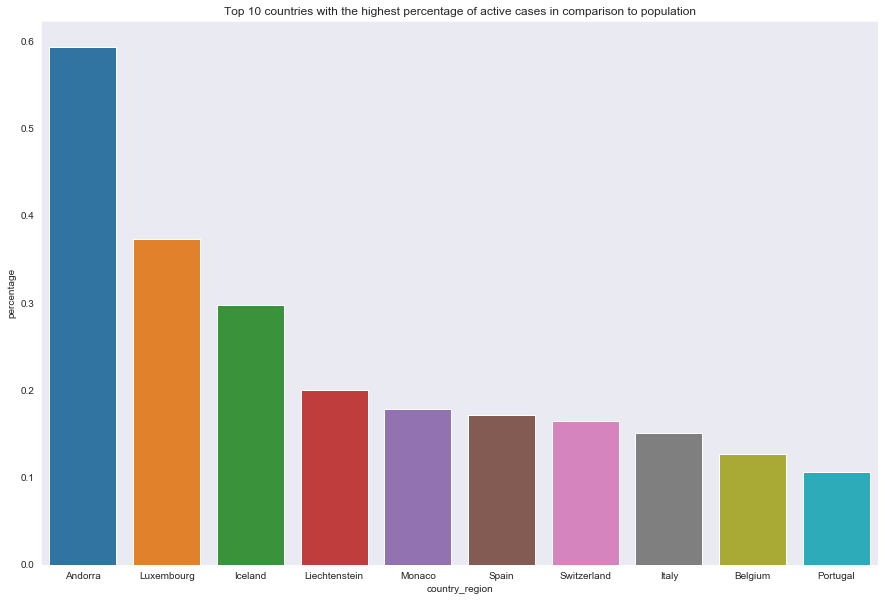

In [ ]:
country_data['percentage'] = country_data['active']/country_data['pop2018']*100
plt.clf()
plt.figure(figsize=(15,10))
ax = sns.barplot(x="country_region", y="percentage", data=country_data.sort_values(by='percentage', ascending=False).head(10))
ax.set_title("Top 10 countries with the highest percentage of active cases in comparison to population")
plt.show()

#### 1st iteration - 5th of April:
The data is from the 5th of April, so it's before the major boom in the United States. We can observe the highest rate in the smallest countries. However see that in the plot we have 4th and 10th biggest European countries: Spain and Italy according to https://www.worldatlas.com/articles/the-largest-countries-in-europe.html.

#### 2nd iteration - 29th of April:
So during one month, the situation changed - Qatar is on top of together with Andorra - 0.4% of these country population is sick, still we can see that most countries that have the highest rate of infection are still in Europe. These countries still need the protection equipment and they can't start losing the restrictions about citizens protecting themselves (Andorra is here in the most need - this country was also in the previous iteration). The happy information is that Spain and Italy are a bit lower in this ranking, so maybe we can see some change in a month there.

The unexpected Qatar score is worrying - this country one month ago was not in this ranking - I think that infection start spread to the south of Europe to the Arabic countries - these countries need to start using protective equipment and start telling the citizens to use it.

So let's see what type of government measures are taken in Qatar and Andorra and compare them with Spain and Italy.

In [ ]:
goverment_measures[(goverment_measures["country"] == "Qatar") | (goverment_measures["country"] == "Andorra")][["country", "measure", "date_implemented"]]

So there is no information in the dataset about any action taken in Andorra, but in the Qatar there is a plenty of actions implemented, so despite the high number of infections rate they can handle the outbreak. The worrying thing is that there  is not such infromation about Andorra.

In [ ]:
goverment_measures[(goverment_measures["country"] == "Spain") | (goverment_measures["country"] == "Italy")].drop_duplicates(subset=["country", "measure"])[["country", "measure", "date_implemented"]]

So comparing the Spain and Italy to Qatar we can tell that both in Spain and in the Italy a lot of precautions were taken, in Qatar the epidemy could started later so they were not been able to implement such big number of measures yet.

Now let's see how the number of active cases compares to the population density. The image below shows the historical diagram with this status as of the 5th of April.

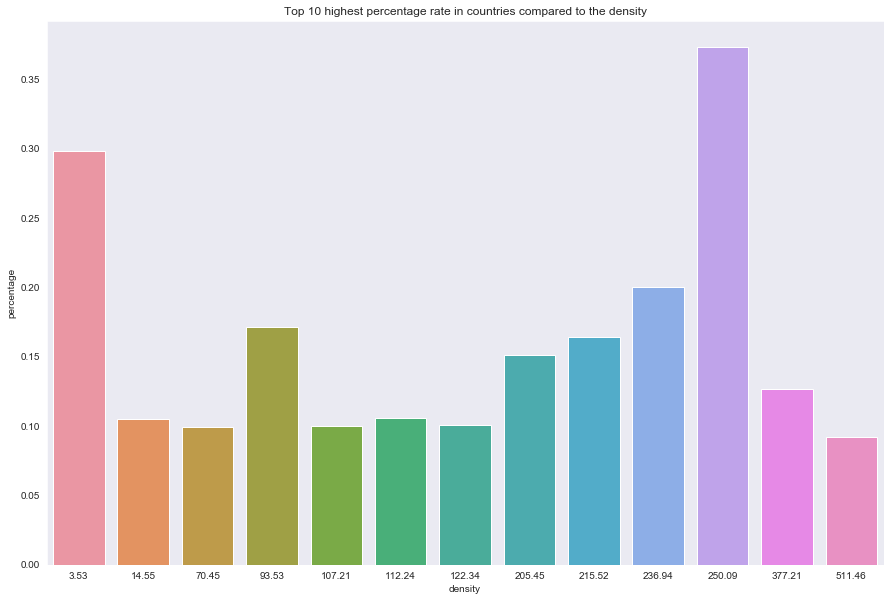

In [ ]:
plt.clf()
plt.figure(figsize=(15,10))
ax = sns.barplot(x="density", y="percentage", data=country_data.sort_values(by="percentage", ascending=False).head(15))
ax.set_title("Top 10 highest percentage rate in countries compared to the density")
plt.show()

#### 1st iteration - 5th of April:

So we can tell that the higher infection rate is correlated with country density, we can observe more active cases above 0.1% of the population for countries with a density above 93 people per square kilometer. So the bigger the density, the higher probability that rate of infection will be high, of course, the density is calculated as the population over the country area - so in some cases, it's not true as we can see for the first country on the diagram. We can see, however, that in some cases, despite the high density the infection rate is relatively small (the last two bars), this can be caused by various reasons, which should be investigated (I'm counting on fast government reaction, people discipline and the fact that the epidemy may only be starting there).

#### 2nd iteration - 29th of April:

Around a month ago the highest rate was around 0.1% of the population, it increased and we can observe that the threshold in the increase of the infections starts at 70.45 people per square kilometer.

Now let's see how the number of active cases looks like in countries based on the percentage of people living in urban areas. The image below shows the historical diagram with this status as of the 5th of April.

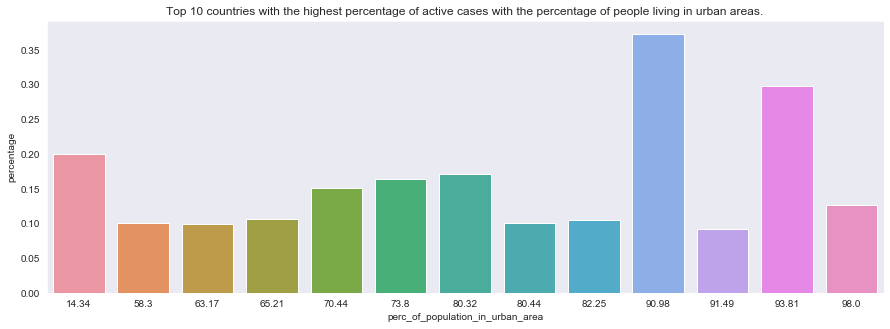

In [ ]:
plt.clf()
plt.figure(figsize=(15,5))
ax = sns.barplot(x="perc_of_population_in_urban_area", y="percentage", data=country_data.sort_values(by="percentage", ascending=False).head(15))
ax.set_title("Top 10 countries with the highest percentage of active cases with the percentage of people living in urban areas.")
plt.show()

Based on this diagram we can tell that when more people are living in the urban areas the infection rate is higher, however, I would not put is as ground truth yet, as we don't know here what is the reason why some countries have this rate so low.

## How countries are handling the testing?

Apart of using the PPE the second thing (and in my opinion the most crucial one) is how testing looks like in the countries because if we are not testing people samples, we can't tell which of them are infected, so we can start isolating them and treatment, which should decrease the infection spread rate.

In order to draw good diagrams based on the clean data, I will start extracting the testing and infection data from the datasets.

In [ ]:
def getLatestCountryDate(entity, df=country_testing):
    return df[df['entity'] == entity].sort_values(by='cumulative_total', ascending=False)['date'].values[0]

def getInfections(entity, df=country_data):
    infections = country_data[country_data['country_region'] == entity]['active'].values
    if entity == 'United States':
        infections = country_data[country_data['country_region'] == 'US']['active'].values
    if len(infections) == 0:
        return 0
    return infections[0]

entities = country_testing['entity'].drop_duplicates().values
tests_total = pd.DataFrame(columns = ['entity', 'total_tests', 'tests_per_thousand'])

for entity in entities:
    tests_total = tests_total.append({'entity' : entity ,
                                      'total_tests' : country_testing[(country_testing['entity']==entity) & (country_testing['date']==getLatestCountryDate(entity))]['cumulative_total'].values[0],
                                      'tests_per_thousand' : country_testing[(country_testing['entity']==entity) & (country_testing['date']==getLatestCountryDate(entity))]['cumulative_total_per_thousand'].values[0]
                                     } , ignore_index=True)
tests_total['population'] = tests_total['entity'].apply(lambda x: getPopulation(x))
tests_total['active_infections'] = tests_total['entity'].apply(lambda x: getInfections(x)) 
tests_total.head()

In [ ]:
plt.clf()
plt.figure(figsize=(15,10))
ax = sns.barplot(x='total_tests', y='entity', data=tests_total.sort_values('active_infections', ascending=False).head(25))
ax.set_title('Number of tests performed by top 25 countries with the biggest number of active cases')
ax.set_xlabel('Total number of tests')
ax.set_ylabel('Country Name')
plt.show()

Based on this information we can tell that the United States has the highest number of active cases, but also the highest number of tests performed. From this diagram, we can tell that some countries require support with testing, but in this diagram, we are biased only to the number of tests performed. These countries can have a different number of people living there, which can impact the bars.

To reduce this bias, let's draw this diagram again, but show their number of tests performed per 1000 people living in these countries.

In [ ]:
plt.clf()
plt.figure(figsize=(15,10))
ax = sns.barplot(x='tests_per_thousand', y='entity', data=tests_total.sort_values('active_infections', ascending=False).head(25))
ax.set_title('Number of tests per 1000 citizens by top 25 countries with the biggest number of active cases')
ax.set_xlabel('Total number of tests')
ax.set_ylabel('Country Name')
plt.show()

So this diagram is more informative. We can see that Ireland and Qatar are performing the biggest number of tests on the citizens (of course some tests may be done twice on some people e.g. the hospital staff). Based on this diagram we can tell that some countries are in drastic need of the tests performed, like India, Ecuador, Iran, Peru, Pakistan, Japan, Poland, and Ukraine. I think some countries like Japan are handling this situation with strict government measures, but others may not be like that. 

I think that for these countries WHO should ask for the reasons why such small number of tests is performed (in Poland, for example, it's possible to do around over 20000 tests per day - according to the news in TV, but by some reasons, this number is greatly smaller - and the restrictions are started to be left). 

Maybe it's possible to start working on some way of "mobile" testing that should increase the number of finding sick people.

## Which US hospitals requires the equipment most?

In this section I would like to see how different states require equipment. Let's gather information about hospitals per state and number of cases per state.

In [ ]:
hospitals = pd.read_csv('/kaggle/input/uncover/esri_covid-19/esri_covid-19/definitive-healthcare-usa-hospital-beds.csv')
hospitals['num_licens'] = hospitals['num_licens'].replace("****", 0)

hospitals['num_licens'] = hospitals['num_licens'].astype('int32')
hospitals['num_icu_be'] = hospitals['num_icu_be'].fillna(0)
hospitals['num_icu_be'] = hospitals['num_icu_be'].astype('int32')

covid_us = pd.read_csv('/kaggle/input/uncover/covid_tracking_project/covid-statistics-by-us-states-totals.csv')
covid_us['hospitalized'] = covid_us['hospitalized'].fillna(0)
covid_us['hospitalized'] = covid_us['hospitalized'].astype('int32')

hospitals.head()

### Number of staff compared to number of cases

Let's see how many licensed personnel is available to treat the patients for different states.

In [ ]:
def getNumberOfStaff(state_code, hospitals = hospitals):
    h = hospitals.groupby('hq_state')['num_licens'].sum().reset_index()
    return h[h['hq_state'] == state_code]['num_licens'].values[0]

def getNumberOfIcuBeds(state_code, hospitals = hospitals):
    h = hospitals.groupby('hq_state')['num_icu_be'].sum().reset_index()
    return h[h['hq_state'] == state_code]['num_icu_be'].values[0]

In [ ]:
df_state = covid_us[['state', 'datemodified', 'hospitalized']].copy()
df_state['active'] = covid_us['positive'].fillna(0) - covid_us['death'].fillna(0)
df_state['active'] = df_state['active'].astype('int32')
df_state['licensed_staff'] = df_state['state'].apply(lambda state: getNumberOfStaff(state))
df_state['icu_beds'] = df_state['state'].apply(lambda state: getNumberOfIcuBeds(state))
df_state['active_per_icu_beds'] = df_state['active']/df_state['icu_beds']
df_state['hospitalized_per_icu_beds'] = (df_state['hospitalized']/df_state['icu_beds'])*100
df_state['active_per_staff'] = df_state['active']/df_state['licensed_staff']
df_state['hospitalized_per_staff'] = df_state['hospitalized']/df_state['licensed_staff']
# df_state.head()

The ICU (Intensive Care Unit) beds are a special type of bed for intensive care patients. They are crucial for treatment the most endangered patients. In the case of the COVID-19, they can support the most critically ill patients providing the respiration.

The image below shows the historical diagram with this status as of the 5th of April.

We need to keep in mind that not all of these patients will require the ICU during the treatment, I'm trying to illustrate here the most pesimistic scenario, when all of them would require them - I don't have an information about the occupation ratio, which could be really helpful in this analysis.

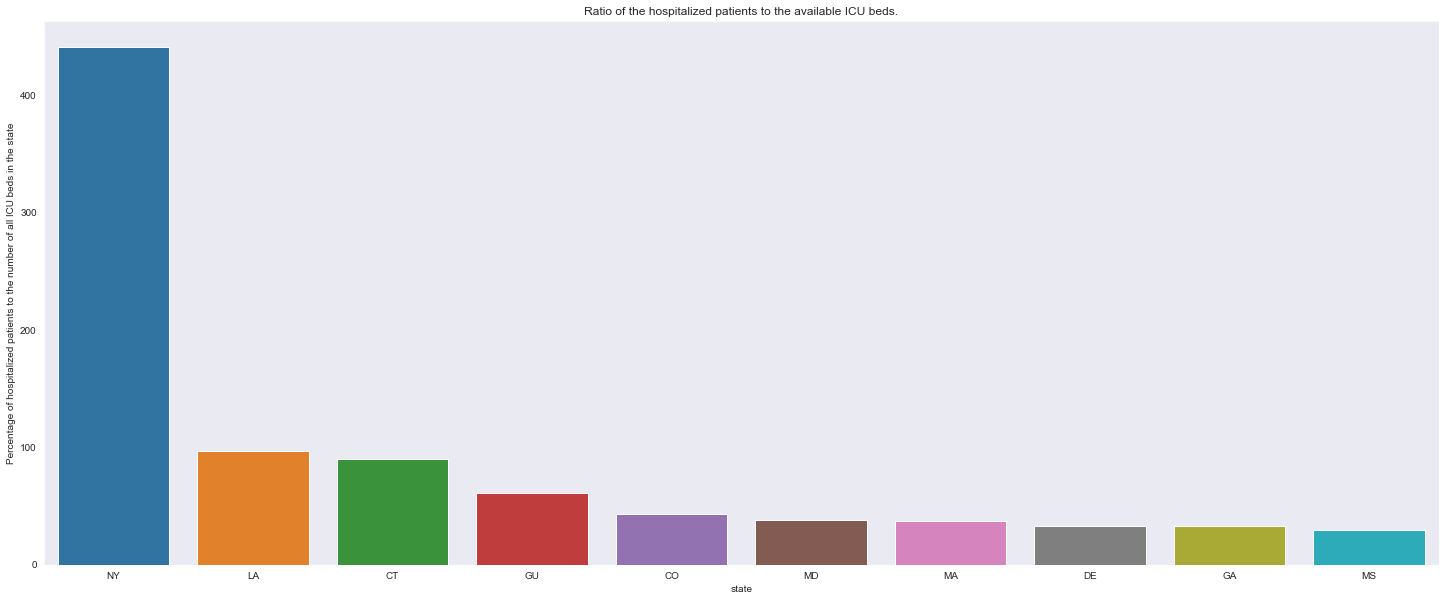

In [ ]:
plt.clf()
plt.figure(figsize=(25,10))
ax = sns.barplot(x='state', y='hospitalized_per_icu_beds', data=df_state.sort_values(by='hospitalized_per_icu_beds', ascending=False).head(10))
ax.set_title("Ratio of the hospitalized patients to the available ICU beds.")
ax.set_ylabel("Percentage of hospitalized patients to the number of all ICU beds in the state")
plt.show()

#### 1st iteration - 5th of April:

So New York has the highest rate of hospitalized people to the availability of ICU beds (over 400%) - due to a big number of hospitalized people the NY hospitals may require additional ICU as the state of some of them may get worse. According to https://newsroom.uw.edu/news/early-study-covid-19-patients-shows-high-mortality-rate the average time spent by COVID-19 patients is 10 days under ICU. We don't know however how many patients will require ICU. But from this diagram, we can tell that at least hospitals in the states: New York (NY), Louisiana(LA) and Connecticut (CT) will require additional ICUs in a short period of time.

#### 2nd iteration - 29th of April:

The New York is still on top of this ranking and the need increased to around 800%, on the second is Maryland (MD) and on the third is Massachusetts (MA), the needs are rising as we can see that month ago this need was not so high for the states except the NY - the US citizens start need to take precautions or else the situation will get worse drastically in the next month.

Please remember that I'm describing here the most pesimistic scenario, as I don't have access to the ICU occupancy ratio.

Now let's see how the number looks for the staff for hospitalized and non-hospitalized patients. The image below shows the historical diagram with this status as of the 5th of April.

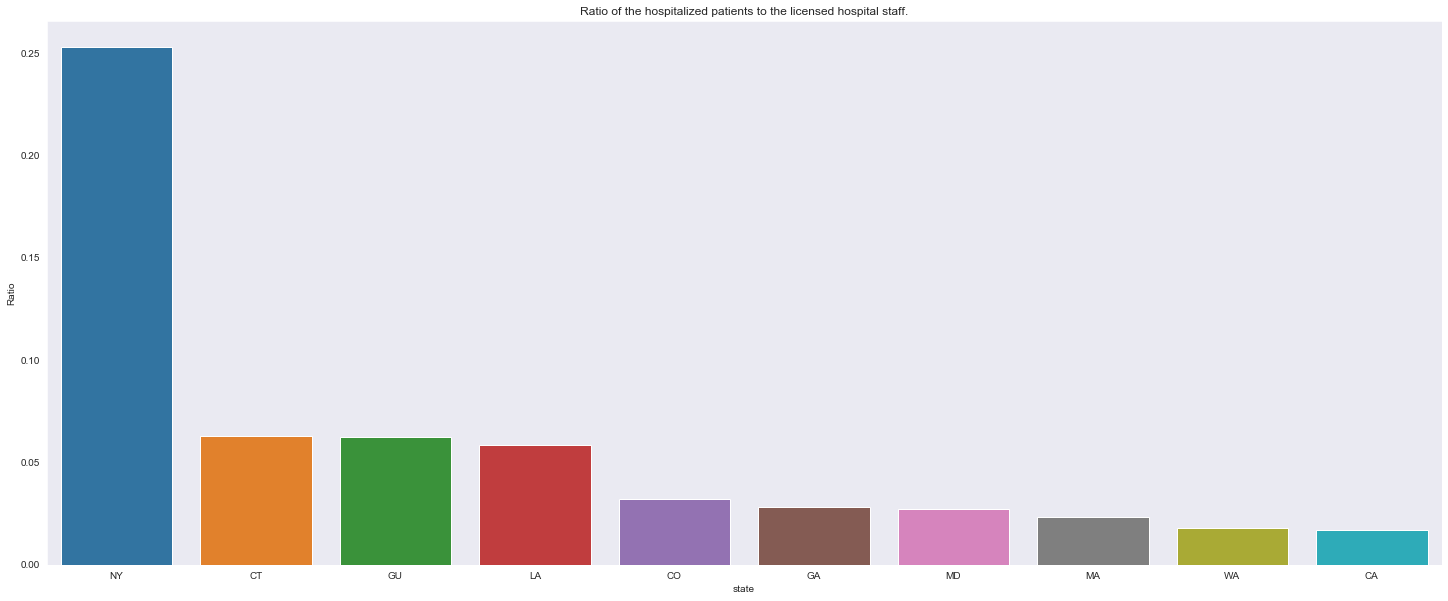

In [ ]:
plt.clf()
plt.figure(figsize=(25,10))
ax = sns.barplot(x='state', y='hospitalized_per_staff', data=df_state.sort_values(by='hospitalized_per_staff', ascending=False).head(10))
ax.set_title("Ratio of the hospitalized patients to the licensed hospital staff.")
ax.set_ylabel("Ratio")
plt.show()

#### 1st iteration - 5th of April:

The NY staff have the highest number of hospitalized patients per one employee - 1 person handles around 4 patients and we here are only the hospitalized patients - the statistics are not showing the information how many of the staff is not working at the hospital directly - e.g. there is no information about the paramedics which are transporting patients between hospitals. If the number of hospitalized patients will increase the hospitals apart of the protective equipment will require staff to perform exchange of tired personnel - the most endangered hospitals are in the New York (NY), Connecticut (CT), Guam (GU) and Louisiana (LA).

#### 2nd iteration - 29th of April:

So in the case of licensed staff the situation also started changing - in the NY 1 staff person need to handle more than 1 sick person, so in the NY apart of the PPE there is a need for a people that will be treating patients. On the second is Maryland (MD) and on the third is Massachusetts (MA) - situation there is similar to the situation in the New York - as we can see what happened for a one month duration in the NY, I think the rest of the states should start preparing for same situation.

Now to see how the situation can change let's see the ratio of the active cases to the staff available. The image below shows the historical diagram with this status as of the 5th of April.

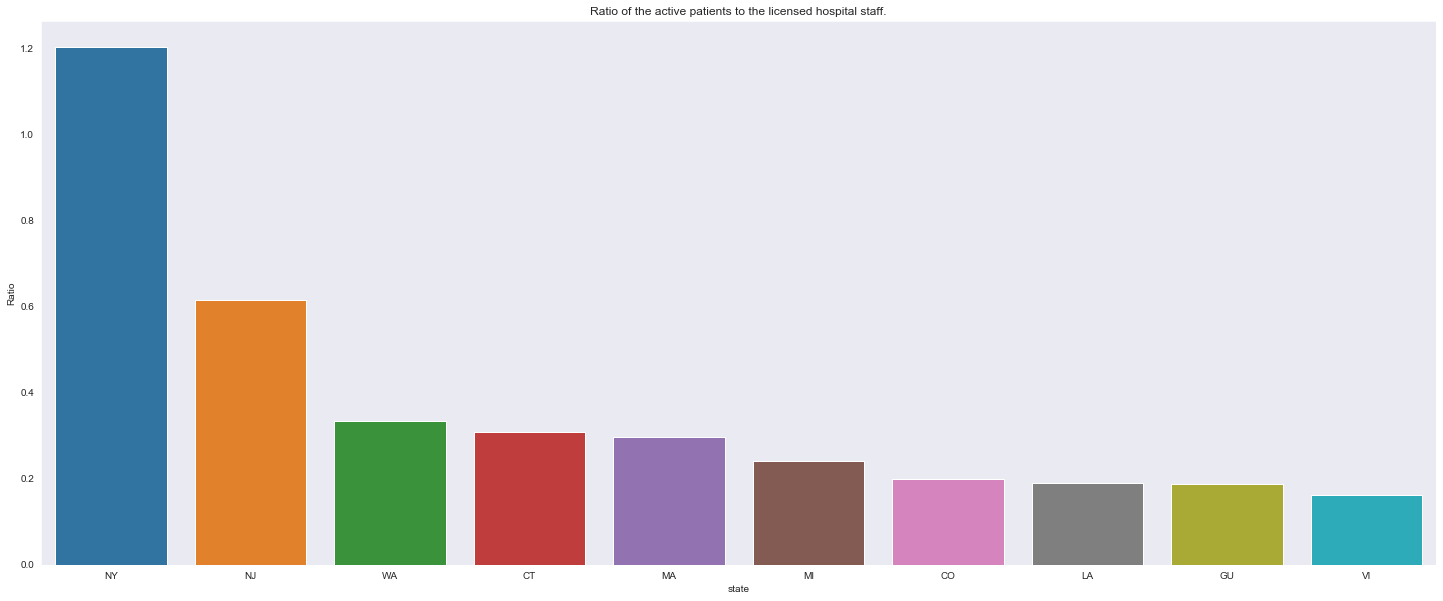

In [ ]:
plt.clf()
plt.figure(figsize=(25,10))
ax = sns.barplot(x='state', y='active_per_staff', data=df_state.sort_values(by='active_per_staff', ascending=False).head(10))
ax.set_title("Ratio of the active patients to the licensed hospital staff.")
ax.set_ylabel("Ratio")
plt.show()

#### 1st iteration - 5th of April:

Again the situation in New York may change and the staff will require additional support (the number of active cases exceeds the number of the staff available). We need to keep in mind that for in this case not only the hospital staff requires the protective equipment, but also other people e.g. police and people that have to maintain the economy like shopkeepers or even cleaning staff, to maintain their safety and the safety of the environment. In the highest need, there are again New York, but also New Jersey, Washington, Connecticut, and Massachusetts.

#### 2nd iteration - 29th of April:

According the the previous descriptions, there is a increase in the sick people in more states, looking on this diagram and on the diagram with hospitalized people compared to the licensed staff, we can observe that 1 out of 5 sick person is in the hospital, which means that there is a lot of people outside the hospitals which need PPE and help. Now the most bad is in the New York, New Jersey, Connecticur, Massechusetts and Maryland - the Washington state is no longer in the top 10, which is a good information.

### All of this information is observational, further summaries should occur based on the more data and should be more region specific.